# The Problem

This is a time series problem, similar to the perceptron one. For this reason we'll only use the previous values as features to predict the next one. 

The difference in this problem is the use of Recurrent Neural Networks

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense


mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["font.size"] = 16
sns.set_theme()

In [3]:
bike = pd.read_csv("data/bicicletas.csv")
bike

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datas        17414 non-null  object 
 1   contagem     17414 non-null  int64  
 2   temperatura  17414 non-null  float64
 3   sensacao     17414 non-null  float64
 4   umidade      17414 non-null  float64
 5   vel_vento    17414 non-null  float64
 6   clima        17414 non-null  float64
 7   feriado      17414 non-null  float64
 8   final_ds     17414 non-null  float64
 9   estacao      17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


A coluna data está como object, precisamos convertê-la para datetime

In [5]:
bike["datas"] = pd.to_datetime(bike["datas"])
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datas        17414 non-null  datetime64[ns]
 1   contagem     17414 non-null  int64         
 2   temperatura  17414 non-null  float64       
 3   sensacao     17414 non-null  float64       
 4   umidade      17414 non-null  float64       
 5   vel_vento    17414 non-null  float64       
 6   clima        17414 non-null  float64       
 7   feriado      17414 non-null  float64       
 8   final_ds     17414 non-null  float64       
 9   estacao      17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


<Axes: xlabel='datas', ylabel='contagem'>

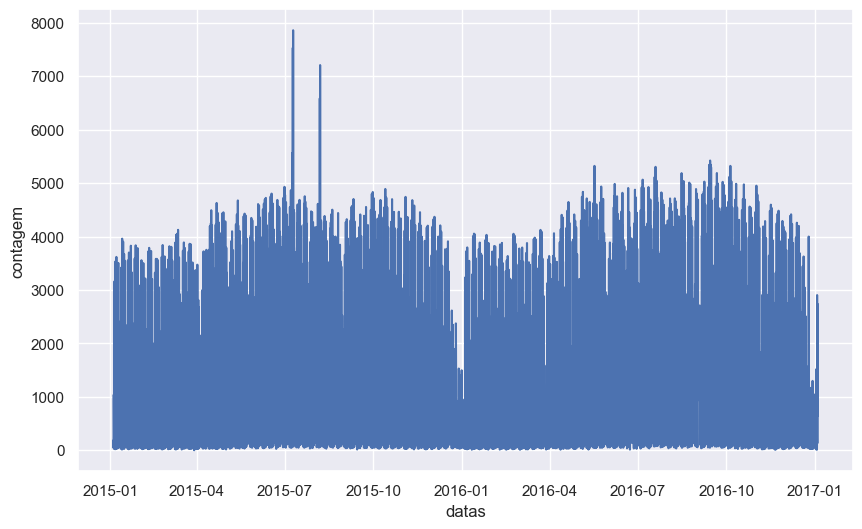

In [6]:
sns.lineplot(x="datas", y="contagem", data=bike)

In [7]:
sc = StandardScaler()
y = sc.fit_transform(bike["contagem"].values.reshape(-1, 1))

In [16]:
tamanho_treino = int(len(bike)*0.9)
tamanho_teste = len(bike) - tamanho_treino

y_treino = y[0:tamanho_treino]
y_teste = y[tamanho_treino:len(bike)]

<Axes: xlabel='datas'>

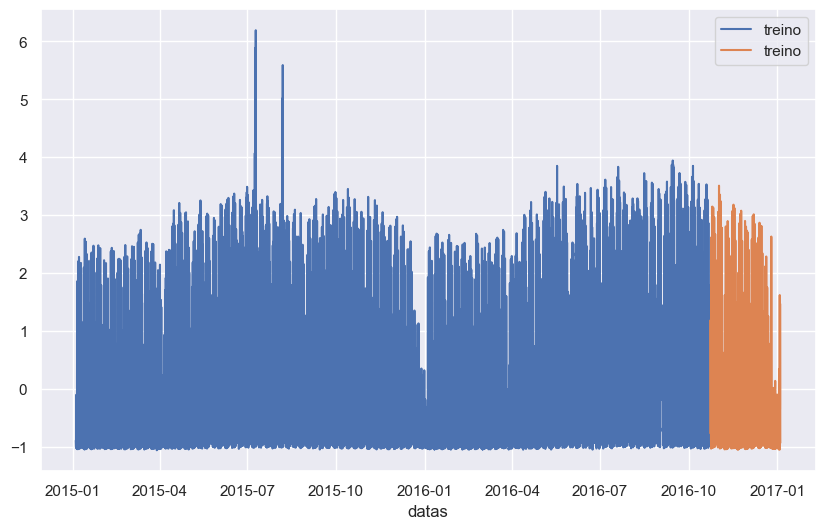

In [18]:
sns.lineplot(x="datas", y=y_treino.reshape(-1), 
             data=bike[0:tamanho_treino], label="treino")
sns.lineplot(x="datas", y=y_teste.reshape(-1), 
             data=bike[tamanho_treino:len(bike)], label="teste")

## Splitting the Data

In [19]:
def separa_dados(vetor, n_passos):
    X_novo, y_novo = [], []

    for i in range(n_passos, vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])
    
    X_novo, y_novo = np.array(X_novo), np.array(y_novo)
    return X_novo, y_novo

In [28]:
vetor = pd.DataFrame(y_treino)[0]
vetor_teste = pd.DataFrame(y_teste)[0]

X_treino_novo, y_treino_novo = separa_dados(vetor, 10)
X_teste_novo, y_teste_novo = separa_dados(vetor_teste, 10)

In [33]:
X_train_novo = X_treino_novo.reshape((
    X_treino_novo.shape[0],
    X_treino_novo.shape[1],
    1
))

X_teste_novo = X_teste_novo.reshape((
    X_teste_novo.shape[0],
    X_teste_novo.shape[1],
    1
))

In [37]:
recorrente = Sequential([
    LSTM(128, input_shape=(X_train_novo.shape[1], X_train_novo.shape[2])),
    Dense(1)
])